### The main objective here focus on prediction
Seoul dataset provide hourly rental data along with weather data

### Data fields

ID - an ID for this instance

Date - year-month-day

Hour - Hour of he day

Temperature - Temperature in Celsius

Humidity - %

Windspeed - m/s

Visibility - 10m

Dew point temperature - Celsius

Solar radiation - MJ/m2

Rainfall - mm

Snowfall - cm

Seasons - Winter, Spring, Summer, Autumn

Holiday - Holiday/No holiday

Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

y - Rented Bike count (Target), Count of bikes rented at each hour

In [1]:
import warnings
warnings.filterwarnings('ignore')

Importing Important Libraries

In [2]:
import numpy as np 
import pandas as pd 
from scipy.stats.mstats import normaltest
from scipy.special import boxcox1p
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_predict
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

In [3]:
path= 'data.csv'
df= pd.read_csv(path)
df.head()

,Id,Date,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Season,IsHoliday,IsFunctioningDay,Bikes_Rented
0,0,01/12/2017,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,254
1,1,01/12/2017,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,204
2,2,01/12/2017,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,173
3,3,01/12/2017,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,107
4,4,01/12/2017,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,78


### EDA

In [4]:
#dropping th Id column as it has no importance
df.drop(['Id'], axis= 1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7260 entries, 0 to 7259
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              7260 non-null   object 
 1   Hour              7260 non-null   int64  
 2   Temperature       7260 non-null   float64
 3   Humidity          7260 non-null   int64  
 4   Wind_Speed        7260 non-null   float64
 5   Visibility        7260 non-null   int64  
 6   Dew_Point         7260 non-null   float64
 7   Solar_Radiation   7260 non-null   float64
 8   Rainfall          7260 non-null   float64
 9   Snowfall          7260 non-null   float64
 10  Season            7260 non-null   object 
 11  IsHoliday         7260 non-null   int64  
 12  IsFunctioningDay  7260 non-null   int64  
 13  Bikes_Rented      7260 non-null   int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 794.2+ KB


Divide the Date into `Year` `Month` and `Day`

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [7]:
df.head()

,Date,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Season,IsHoliday,IsFunctioningDay,Bikes_Rented,Year,Month,Day
0,2017-01-12,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,254,2017,1,12
1,2017-01-12,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,204,2017,1,12
2,2017-01-12,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,173,2017,1,12
3,2017-01-12,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,107,2017,1,12
4,2017-01-12,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,78,2017,1,12


In [8]:
# We can drop Year as it has no effect or training the model
df.Year.nunique()

2

In [9]:
df.drop(['Year'], axis= 1, inplace=True)

Checking for the null values

In [10]:
df.isna().sum()

Date                0
Hour                0
Temperature         0
Humidity            0
Wind_Speed          0
Visibility          0
Dew_Point           0
Solar_Radiation     0
Rainfall            0
Snowfall            0
Season              0
IsHoliday           0
IsFunctioningDay    0
Bikes_Rented        0
Month               0
Day                 0
dtype: int64

See some relationships between the target and features

In [11]:
def boxplot_sorted(df, by, column):
  plt.figure(figsize=(20,9))
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
  df2[meds.index].boxplot(rot=90)

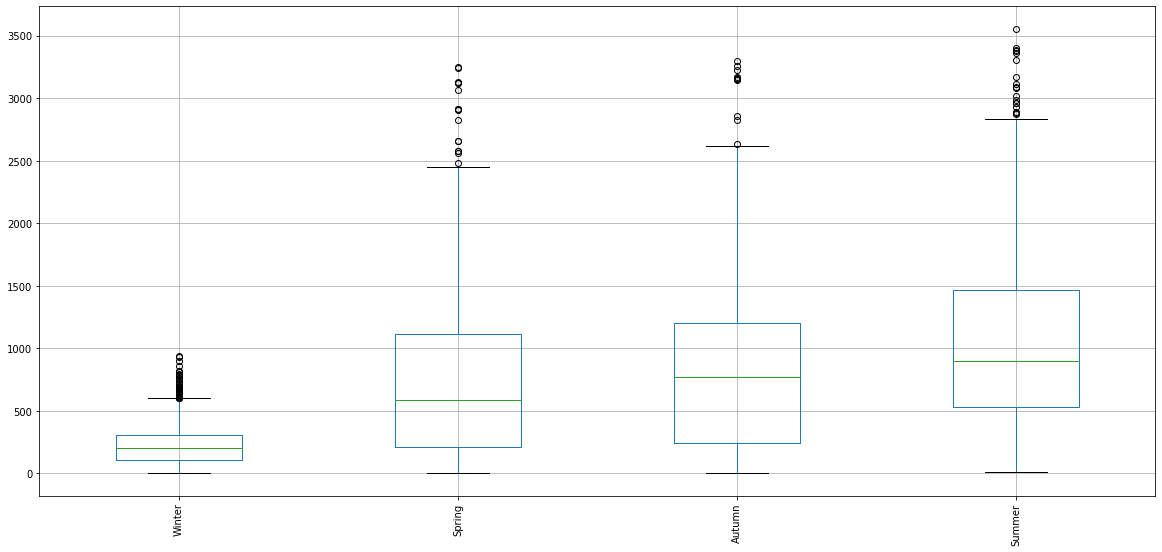

In [12]:
boxplot_sorted(df, by=["Season"], column="Bikes_Rented")

In [13]:
y_col = "Bikes_Rented"

X1 = df.drop(y_col, axis=1)
y = df[y_col]

# dropping Date column as we divided it into year, month, and day columns
X1= X1.drop('Date', axis=1)

### Feature Engineering

<AxesSubplot:>

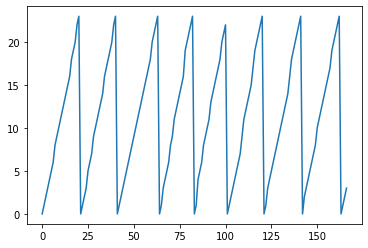

In [14]:
# First week of data 24*7=168
X1.Hour[:167].plot()

Here we see the cyclic nature of Hours between 00 and 23 that repeat itself 7 times, it also introduces jump discontinuities between 23 and 00 which is a problem to our linear models; using tree-based algorithms might be robust to the cyclic features

The difference in time between 11 and 10 is 1 hour, but between 00 and 23 is -23 which is not true

#### Encoding Cyclic Feature

In [15]:
# Assuring that all unique values are present
print(X1.Month.unique())
print(X1.Day.unique())
print(X1.Hour.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4
  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 19 20 22 23  7 17 21]


In [16]:
def encode(data, cols, max_vals):
    X= data.copy()
    for col, max_val in zip(cols, max_vals):
        X[col + '_sin'] = np.sin(2 * np.pi * X[col]/max_val)
        X[col + '_cos'] = np.cos(2 * np.pi * X[col]/max_val)
        X.drop([col], axis= 1, inplace=True)
    return X

In [17]:
X2 = encode(X1, ['Day', 'Month', 'Hour'], [31.0, 12.0, 24.0])

In [18]:
X2.head()

,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Season,IsHoliday,IsFunctioningDay,Day_sin,Day_cos,Month_sin,Month_cos,Hour_sin,Hour_cos
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0.651372,-0.758758,0.5,0.866025,0.000000,1.000000
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0.651372,-0.758758,0.5,0.866025,0.258819,0.965926
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,0.651372,-0.758758,0.5,0.866025,0.500000,0.866025
3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0.651372,-0.758758,0.5,0.866025,0.707107,0.707107
4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,0.651372,-0.758758,0.5,0.866025,0.866025,0.500000


In [21]:
# Getting the numerical columns for the histogram
_num_cols= X2.select_dtypes('number').columns
_num_cols

Index(['Temperature', 'Humidity', 'Wind_Speed', 'Visibility', 'Dew_Point',
       'Solar_Radiation', 'Rainfall', 'Snowfall', 'IsHoliday',
       'IsFunctioningDay', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Hour_sin', 'Hour_cos'],
      dtype='object')

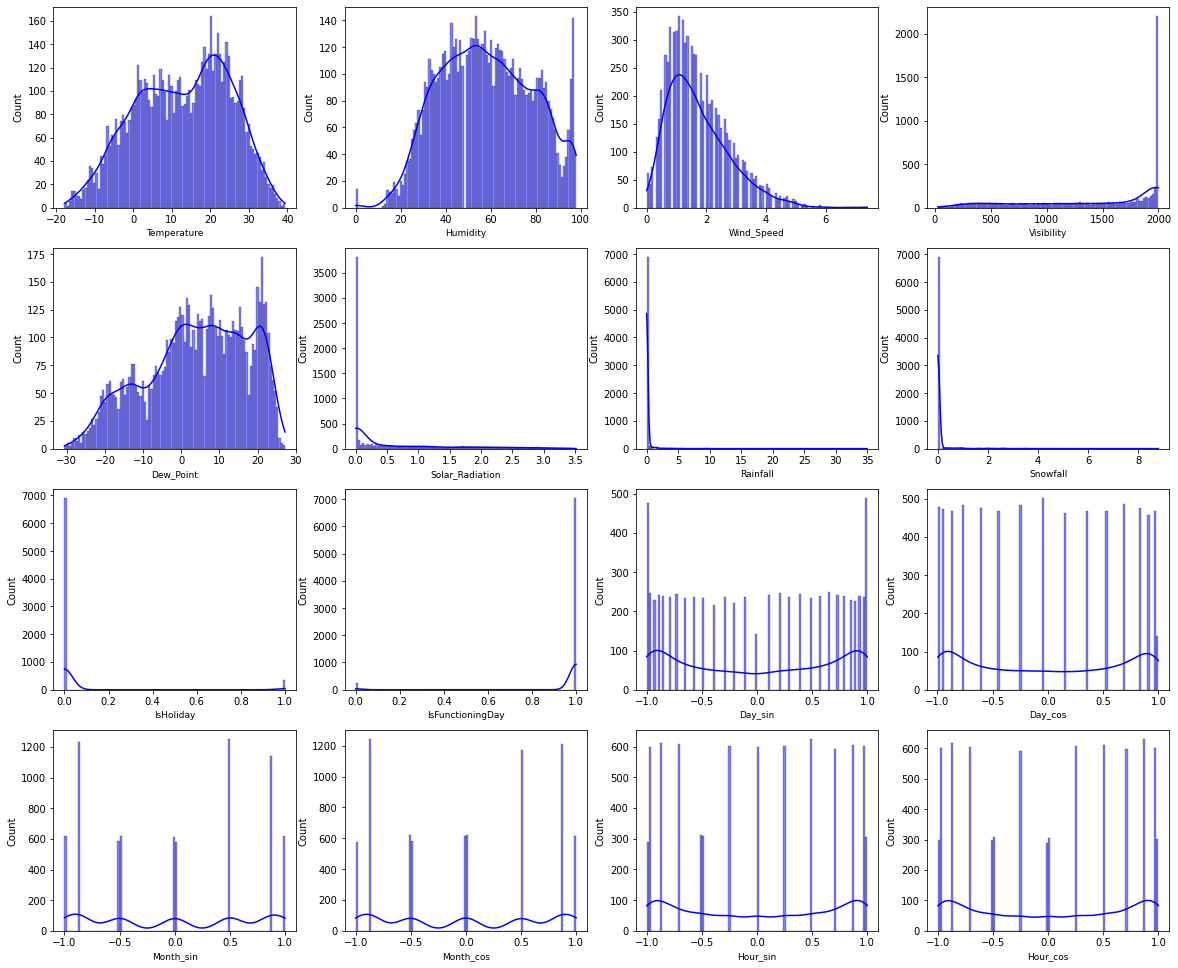

In [24]:
fig, ax = plt.subplots(4, 4, figsize=(20, 17))
for i, feature in enumerate(_num_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(X2[feature], 
                 color="blue", 
                 kde=True, 
                 bins=100)
    plt.xlabel(feature, fontsize=9)
plt.show()

#### Applying Transformations

In [25]:
skew_limit= 0.75
skew_vals= X2.skew()
skew_vals.sort_values(ascending= True)

IsFunctioningDay    -5.260997
Visibility          -0.706273
Dew_Point           -0.369098
Temperature         -0.193376
Day_sin             -0.008872
Hour_cos            -0.006207
Hour_sin             0.000781
Month_cos            0.006850
Month_sin            0.011157
Day_cos              0.026724
Humidity             0.064911
Wind_Speed           0.936457
Solar_Radiation      1.498406
IsHoliday            4.117080
Snowfall             8.176801
Rainfall            14.824762
dtype: float64

In [26]:
skew_cols= skew_vals[abs(skew_vals) > skew_limit].sort_values(ascending= True)
skew_cols

IsFunctioningDay    -5.260997
Wind_Speed           0.936457
Solar_Radiation      1.498406
IsHoliday            4.117080
Snowfall             8.176801
Rainfall            14.824762
dtype: float64

In [27]:
plot_data= pd.DataFrame(skew_cols).index.values

In [28]:
# This function help us visualize the transformation
def plot_dist(str_data, _df):
    for s in str_data:
        fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(11, 6))
        _df[s].hist(ax=ax_before)
        _df['Transformed_' + s].hist(ax=ax_after)
        ax_before.set(title='Before Transformation', ylabel='frequency', xlabel='value')
        ax_after.set(title='After Transformation', ylabel='frequency', xlabel='value')
        fig.suptitle(s)

##### Log Transformation

In [30]:
# testing the log transformation on skewed columns
test= X2.copy()
for col in skew_cols.index.values:
    test['Transformed_' + col] = X2[col].apply(np.log1p)

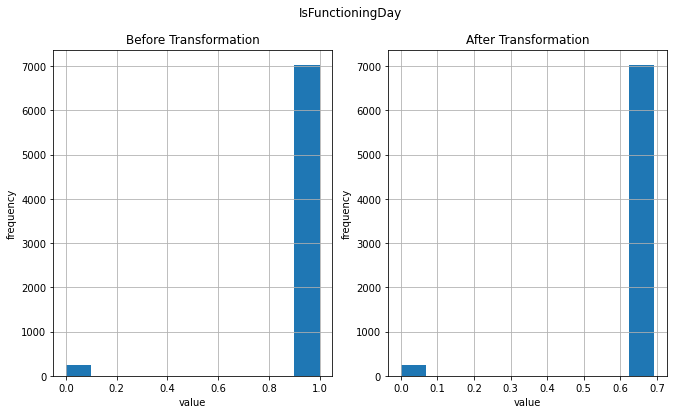

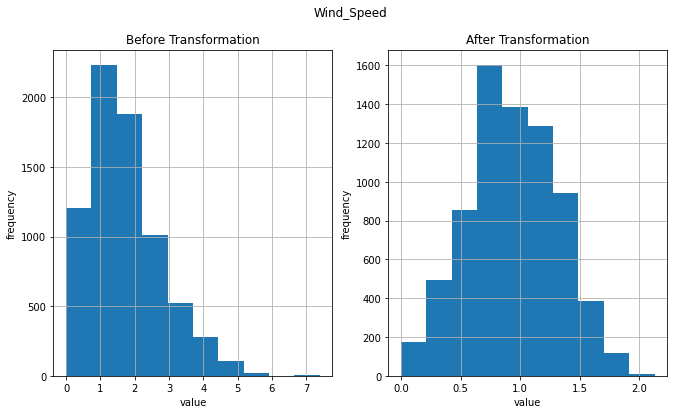

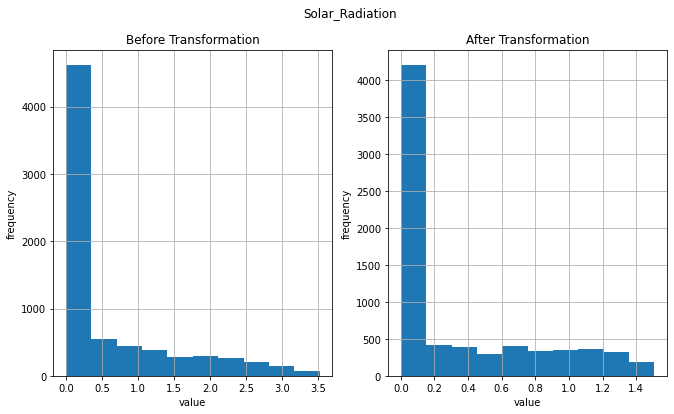

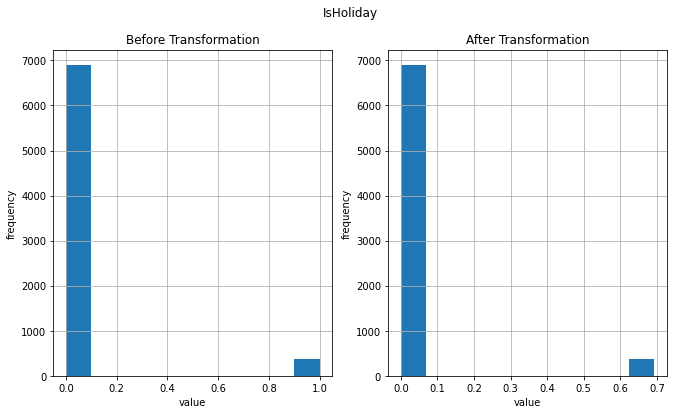

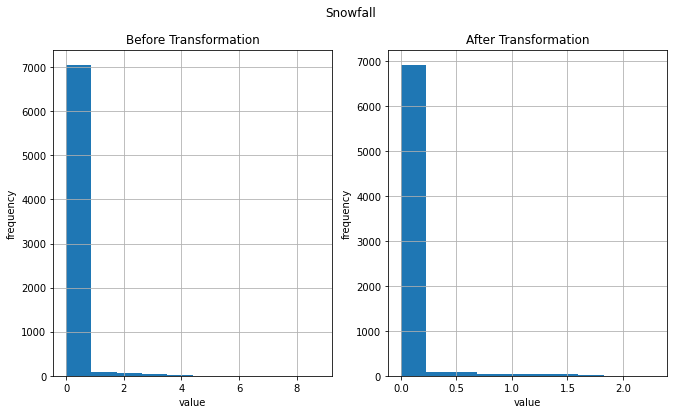

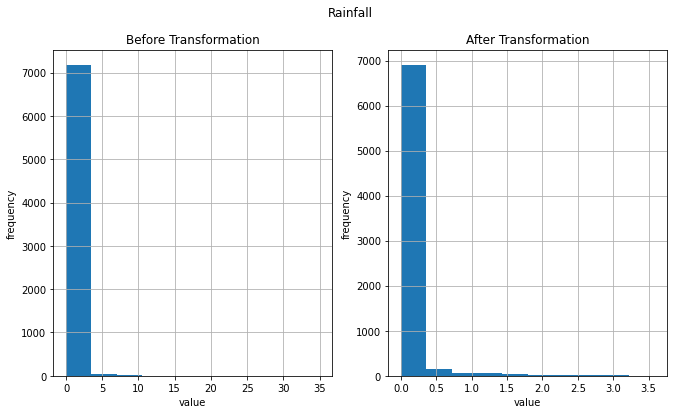

In [31]:
plot_dist(plot_data, test)

In [32]:
for col in skew_cols.index.values:
    print("{} : {}".format(col, normaltest(test['Transformed_' + col])))

IsFunctioningDay : NormaltestResult(statistic=7276.078305292504, pvalue=0.0)
Wind_Speed : NormaltestResult(statistic=87.96787959816213, pvalue=7.907107675974504e-20)
Solar_Radiation : NormaltestResult(statistic=986.9910360211873, pvalue=4.760139540887767e-215)
IsHoliday : NormaltestResult(statistic=5925.362429658874, pvalue=0.0)
Snowfall : NormaltestResult(statistic=7904.255326177218, pvalue=0.0)
Rainfall : NormaltestResult(statistic=8675.457176164524, pvalue=0.0)


p-value is too small so we reject that transformation

##### Boxcox Transformation

In [33]:
# testing boxcox transformation on the skewed data
# boxcox1p to avoid errors with 0 values
test= X2.copy()
for col in skew_cols.index.values:
    test['Transformed_' + col] = X2[col].apply(lambda x: boxcox1p(x, 0.25))

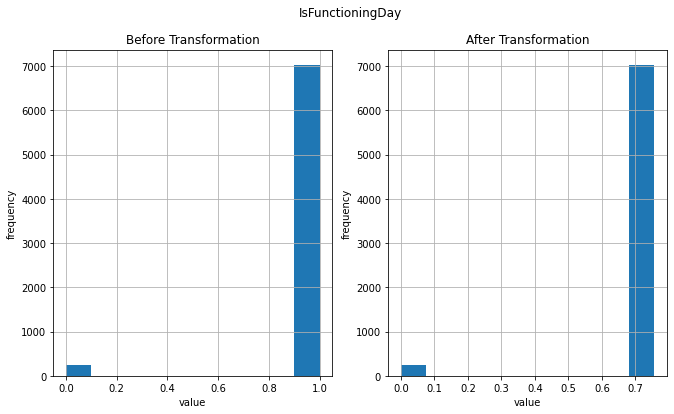

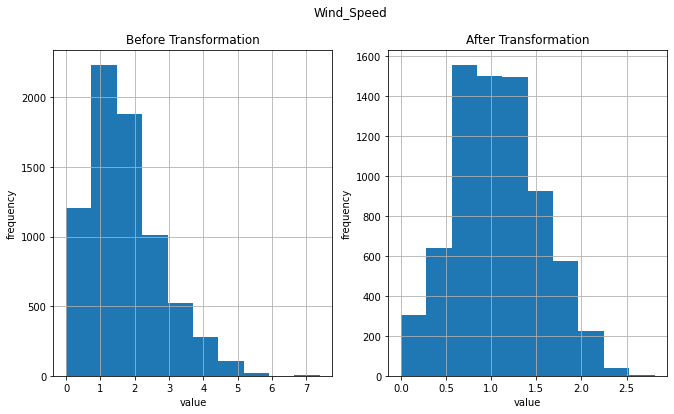

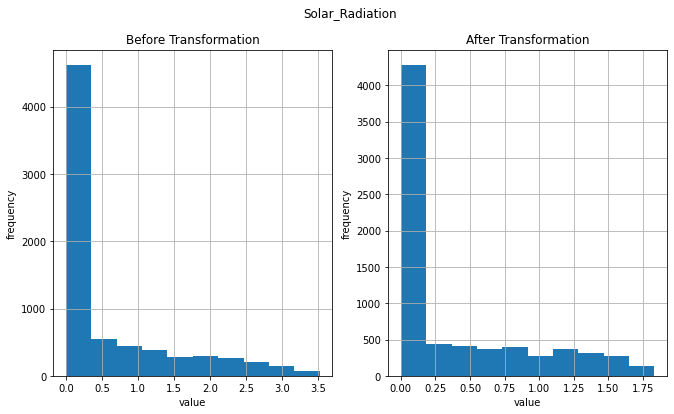

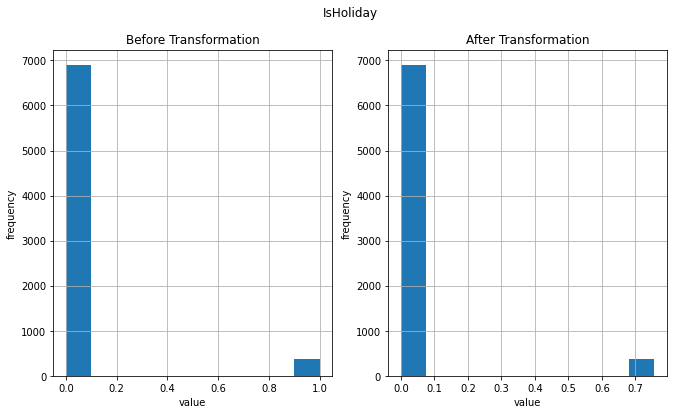

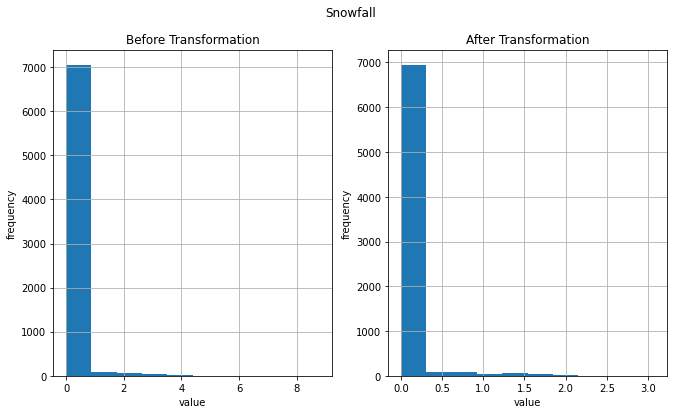

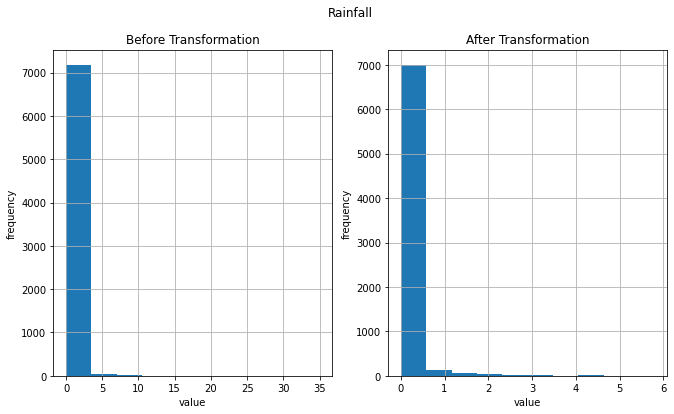

In [34]:
plot_dist(plot_data, test)

In [35]:
for col in skew_cols.index.values:
    print("{} : {}".format(col, normaltest(test['Transformed_' + col])))

IsFunctioningDay : NormaltestResult(statistic=7276.0783052925035, pvalue=0.0)
Wind_Speed : NormaltestResult(statistic=127.43039470429261, pvalue=2.1322659737465196e-28)
Solar_Radiation : NormaltestResult(statistic=1067.1437354228117, pvalue=1.8736227631630675e-232)
IsHoliday : NormaltestResult(statistic=5925.362429658874, pvalue=0.0)
Snowfall : NormaltestResult(statistic=8287.488704908797, pvalue=0.0)
Rainfall : NormaltestResult(statistic=9648.070944755664, pvalue=0.0)


p-value is small again so we reject the transformation

##### Square root Transformation

In [36]:
# testing square root on the skewed data
test= X2.copy()
for col in skew_cols.index.values:
    test['Transformed_' + col] = X2[col].apply(np.sqrt)

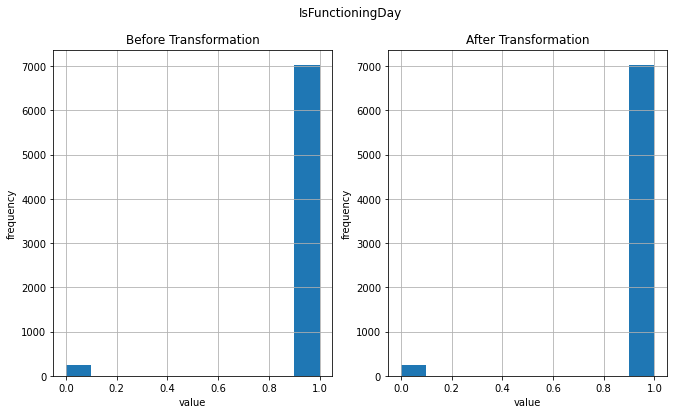

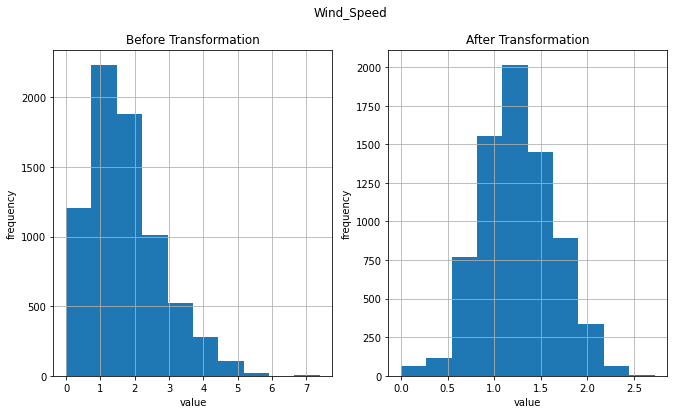

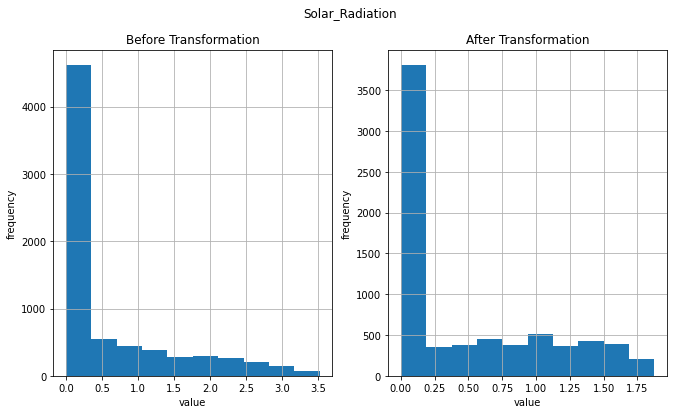

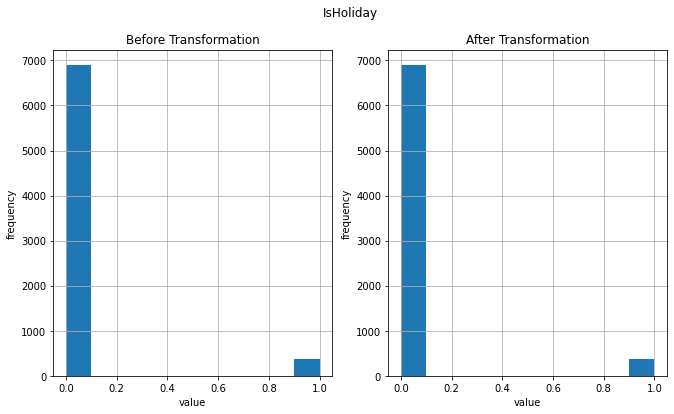

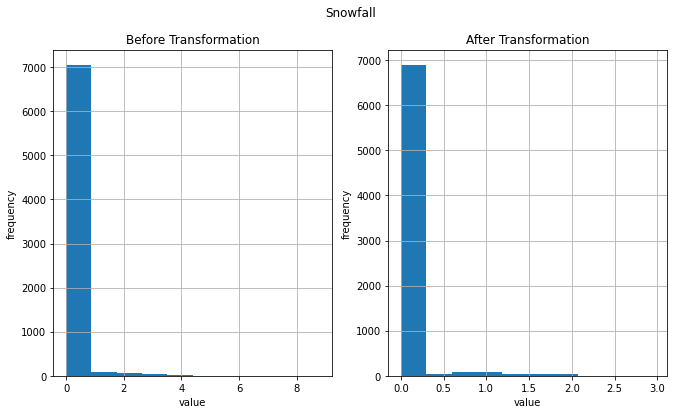

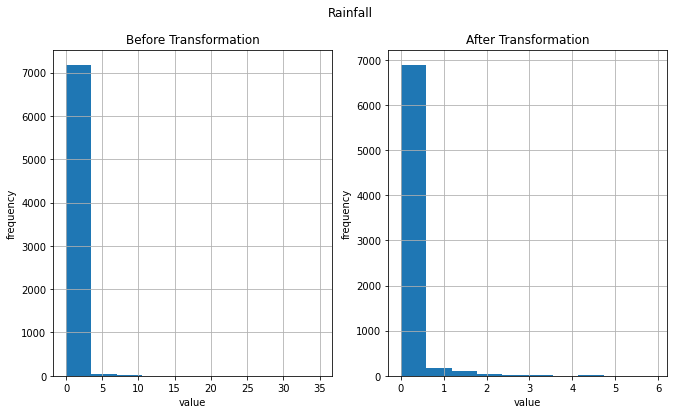

In [37]:
plot_dist(plot_data, test)

In [38]:
for col in skew_cols.index.values:
    print("{} : {}".format(col, normaltest(test['Transformed_' + col])))

IsFunctioningDay : NormaltestResult(statistic=7276.078305292505, pvalue=0.0)
Wind_Speed : NormaltestResult(statistic=3.4271266320926173, pvalue=0.18022245751991253)
Solar_Radiation : NormaltestResult(statistic=1295.764460841063, pvalue=4.249349038483339e-282)
IsHoliday : NormaltestResult(statistic=5925.362429658874, pvalue=0.0)
Snowfall : NormaltestResult(statistic=7384.809538801601, pvalue=0.0)
Rainfall : NormaltestResult(statistic=8928.378866683832, pvalue=0.0)


p-value looks good on Wind_speed so we accept the transformation for Wind_speed

#### Observations regards the zero-inflated features

In [100]:
# Here 0.0 represents ~50% of the data while the second highest count represents ~1%; this is called zero-inflated feature and a way to deal
# with it might be using two-model/stage regression.
# Start by modeling the binary response (e.g. logistic, zero vs. non-zero), then run the non-zero responses with your favorite regression

# Another way would be using Neural Networks

# This might be a future work as it's not handled in this notebook

X2.Solar_Radiation.value_counts(ascending= False) / X2.Solar_Radiation.count()

0.00    0.492424
0.01    0.014325
0.02    0.009917
0.03    0.007989
0.06    0.006612
          ...   
3.41    0.000138
3.35    0.000138
3.32    0.000138
3.45    0.000138
3.08    0.000138
Name: Solar_Radiation, Length: 341, dtype: float64

In [102]:
# ~95% of the data is zeros
X2.Snowfall.value_counts(ascending= False) / X2.Snowfall.count()

0.0    0.949174
1.0    0.004821
0.3    0.004683
0.5    0.004408
0.7    0.003444
0.9    0.003306
0.8    0.002755
2.0    0.002755
0.4    0.002342
1.6    0.002204
2.2    0.002066
0.2    0.001791
3.5    0.001791
0.6    0.001653
2.6    0.001515
2.7    0.000826
1.2    0.000826
2.5    0.000826
1.8    0.000689
4.0    0.000551
1.3    0.000551
3.0    0.000551
1.7    0.000413
3.3    0.000413
1.1    0.000413
4.1    0.000413
1.9    0.000413
2.4    0.000413
3.4    0.000275
2.9    0.000275
3.8    0.000275
0.1    0.000275
3.2    0.000275
5.0    0.000275
4.8    0.000275
4.3    0.000275
3.7    0.000275
7.0    0.000138
3.6    0.000138
8.8    0.000138
7.1    0.000138
1.4    0.000138
3.9    0.000138
1.5    0.000138
2.8    0.000138
3.1    0.000138
4.2    0.000138
2.1    0.000138
Name: Snowfall, dtype: float64

In [103]:
# ~94% zeros
X2.Rainfall.value_counts(ascending= False) / X2.Rainfall.count()

0.0     0.939532
0.5     0.012948
1.0     0.007989
1.5     0.007300
0.1     0.005510
2.0     0.003030
2.5     0.002617
0.2     0.002204
3.5     0.001928
0.4     0.001928
3.0     0.001653
4.0     0.001515
5.5     0.000826
0.3     0.000826
9.5     0.000826
6.0     0.000689
4.5     0.000689
6.5     0.000551
5.0     0.000551
9.0     0.000551
0.8     0.000413
0.9     0.000413
1.6     0.000413
7.0     0.000413
18.5    0.000275
8.0     0.000275
18.0    0.000275
13.0    0.000275
8.5     0.000275
1.1     0.000138
24.0    0.000138
7.3     0.000138
17.0    0.000138
1.3     0.000138
15.5    0.000138
29.5    0.000138
12.0    0.000138
9.1     0.000138
21.0    0.000138
14.5    0.000138
21.5    0.000138
4.9     0.000138
16.0    0.000138
0.7     0.000138
5.4     0.000138
11.5    0.000138
10.0    0.000138
19.0    0.000138
35.0    0.000138
2.4     0.000138
3.3     0.000138
1.9     0.000138
1.8     0.000138
Name: Rainfall, dtype: float64

The `IsFunctioningDay` and `IsHoliday` are binary columns so we ignore them, the values of `Solar_Radiation`, `Snowfall`, and `Rainfall` are extreamly skewed, almost all readings are zeros (Zero-inflated features)

### Preprocessing the data

In [76]:
# convert an existing Python function into a transformer to assist in data cleaning or processing
def sqrt_transformer(x):
    x= np.abs(x)
    return np.sqrt(x)

sq_transformer = FunctionTransformer(sqrt_transformer)

In [104]:
# Getting the numerical and categorical feature names, then converting it to numpy array
num_features= X2.select_dtypes('number').columns
cat_features= X2.select_dtypes('object').columns
_num_features= num_features.values
_cat_features= cat_features.values

In [167]:
pf = PolynomialFeatures(degree=2, include_bias=False)
s = StandardScaler()
ohc = OneHotEncoder(drop= 'first', sparse= False)

In [168]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn_pandas import DataFrameMapper

In [169]:
lr = LinearRegression()

In [170]:
X_train, X_test, y_train, y_test= train_test_split(X2, y, test_size= 0.2, random_state= 42)
kf = KFold(shuffle=True, random_state=42, n_splits=5)

In [171]:
num_imputer= SimpleImputer(strategy='median')
cat_imputer= SimpleImputer(strategy='constant', fill_value='most_frequent')

Here we use [DataFrameMapper](https://github.com/scikit-learn-contrib/sklearn-pandas) which is a very effective way to deal with several `DataFrame` columns with `sklearn` transformations

`Season`: We apply categorical imputation then OnehotEncoder
`Wind_speed`: We apply numerical imputation then `StandardScaler` then Square root transformation
Others: the rest of columns we apply only numerical transformation the `StandardScaler`

For numerical values, after the previous processes we apply `PolynomialFeatures` with degree 2

In [172]:
mapper= DataFrameMapper([
    (['Season'], [cat_imputer, ohc])
], df_out= True)

mapper2= DataFrameMapper([
    (['Wind_Speed'], [num_imputer, s, sq_transformer]),
    (['Temperature'], [num_imputer, s]),
    (['Humidity'], [num_imputer, s]),
    (['Visibility'], [num_imputer, s]),
    (['Dew_Point'], [num_imputer, s]),
    (['Solar_Radiation'], [num_imputer, s]),
    (['Rainfall'], [num_imputer, s]),
    (['Snowfall'], [num_imputer, s]),
    (['Day_sin'], [num_imputer, s]),
    (['Day_cos'], [num_imputer, s]),
    (['Month_sin'], [num_imputer, s]),
    (['Month_cos'], [num_imputer, s]),
    (['Hour_sin'], [num_imputer, s]),
    (['Hour_cos'], [num_imputer, s]),
    (['IsHoliday'], [num_imputer, s]),
    (['IsFunctioningDay'], [num_imputer, s])
], df_out= True)


tf1= Pipeline(steps=[
    ('mapper', mapper)])

tf2= Pipeline(steps=[
    ('mapper2', mapper2),
    ('ploynomial', pf)
])


transformer= ColumnTransformer(
    transformers=[
        ('cat_transformer', tf1, _cat_features),
        ('num_transformer', tf2, _num_features)
    ]
)

In [173]:
# getting the new transformed data
X_train_trans= transformer.fit_transform(X_train)
X_train_trans.shape

(5808, 155)

In [174]:
X_test_trans= transformer.transform(X_test)
X_test_trans.shape

(1452, 155)

### Modeling

#### Linear Regression

In [175]:
lr.fit(X_train_trans, y_train)
y_train_pred = lr.predict(X_train_trans)
y_test_pred = lr.predict(X_test_trans)

In [188]:
print(f'mse: {mean_squared_error(y_train, y_train_pred)}')
print(f'R^2 (test): {r2_score(y_train,y_train_pred)}')

mse: 96408.5377965517
R^2 (test): 0.7679088805840516


In [189]:
print(f'mse: {mean_squared_error(y_test,  y_test_pred)}')
print(f'R^2 (test): {r2_score(y_test, y_test_pred)}')

mse: 93399.64193423856
R^2 (test): 0.7778101458475999


In [194]:
# most impactful features
pd.DataFrame(zip(X_train.columns, lr.coef_)).sort_values(by=1)

,0,1
12,Day_cos,-6.077264e+09
16,Hour_cos,-5.814765e+08
15,Hour_sin,-4.820460e+08
13,Month_sin,-2.810398e+08
9,IsHoliday,-1.129493e+03
4,Dew_Point,-1.020814e+03
5,Solar_Radiation,-4.300215e+02
0,Temperature,-1.730868e+02
2,Wind_Speed,-1.544385e+02
1,Humidity,-6.248168e+01


Using `cross_val_predict` instead of `train_test_split`

In [196]:
X2_trans= transformer.fit_transform(X2)

In [198]:
predictions= cross_val_predict(lr, X2_trans, y, cv=kf)

In [203]:
print(f'mse: {mean_squared_error(y,  predictions)}')
print(f'R^2 (test): {r2_score(y, predictions)}')

mse: 107399.8658802247
R^2 (test): 0.742069142334017


In [207]:
pd.DataFrame(zip(X2.columns, lr.coef_)).sort_values(by=1)

,0,1
12,Day_cos,-6.077264e+09
16,Hour_cos,-5.814765e+08
15,Hour_sin,-4.820460e+08
13,Month_sin,-2.810398e+08
9,IsHoliday,-1.129493e+03
4,Dew_Point,-1.020814e+03
5,Solar_Radiation,-4.300215e+02
0,Temperature,-1.730868e+02
2,Wind_Speed,-1.544385e+02
1,Humidity,-6.248168e+01


[Text(0.5, 0, 'Ground truth'),
 Text(0, 0.5, 'Predictions'),
 Text(0.5, 1.0, 'Seoul bike rental Predictions vs Truth, using Linear Regression')]

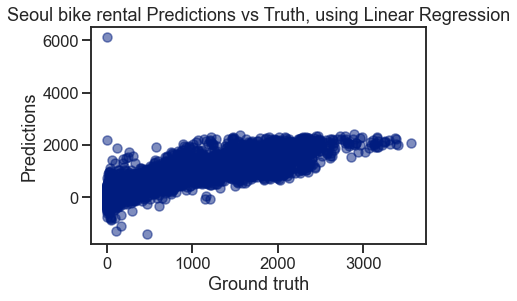

In [208]:
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y, predictions, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Seoul bike rental Predictions vs Truth, using Linear Regression')

#### Lasso Regression

In [209]:
alphas = np.geomspace(1e-9, 1e0, num=10)

scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    predictions = cross_val_predict(las, X2_trans, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [211]:
list(zip(alphas,scores))

[(1e-09, 0.7425220111571804),
 (1e-08, 0.7425220109345294),
 (1e-07, 0.7425220087079296),
 (1e-06, 0.7425219864079965),
 (1e-05, 0.7425217660307075),
 (0.0001, 0.7425195631028567),
 (0.001, 0.7424980664536565),
 (0.01, 0.7422430968823628),
 (0.1, 0.7429731401936025),
 (1.0, 0.7524554618838158)]

Text(0, 0.5, '$R^2$')

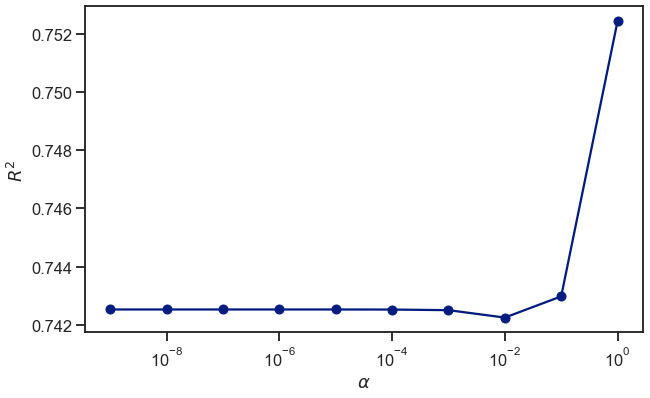

In [212]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')

In [223]:
alphas = np.geomspace(1.0, 5.0, 10)

scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    predictions = cross_val_predict(las, X2_trans, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [224]:
list(zip(alphas,scores))

[(1.0, 0.7524554618838158),
 (1.195813174500402, 0.752636216851876),
 (1.4299691483087287, 0.7524619301616786),
 (1.709975946676697, 0.751724260980327),
 (2.0448117651147912, 0.7501272717794387),
 (2.4452128480976887, 0.7476340831169599),
 (2.924017738212866, 0.7444173866927677),
 (3.4965789338278133, 0.7414097239213246),
 (4.1812551547518675, 0.7377633282624887),
 (5.000000000000001, 0.7334462991542545)]

Text(0, 0.5, '$R^2$')

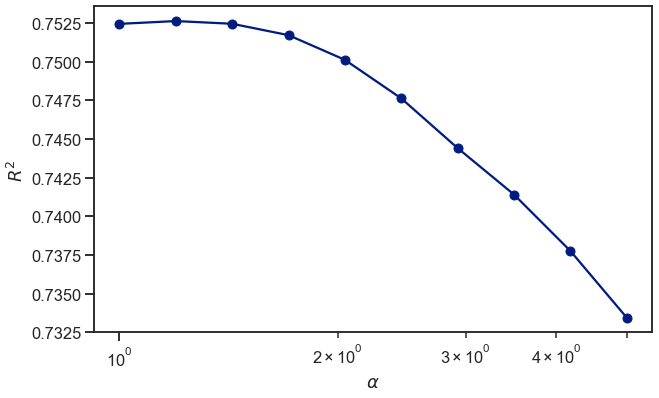

In [225]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')

In [239]:
# applying fit to get the .coef_
best_las= Lasso(alpha=1.2).fit(X2_trans, y)

In [240]:
predictions= cross_val_predict(best_las, X2_trans, y, cv=kf)

In [241]:
print(f'mse: {mean_squared_error(y,  predictions)}')
print(f'R^2 (test): {r2_score(y, predictions)}')

mse: 102993.88563054655
R^2 (test): 0.7526505174162378


In [257]:
col_names_dict = dict(zip(list(range(len(X2.columns.values))), X2.columns.values))
col_names_dict

{0: 'Temperature',
 1: 'Humidity',
 2: 'Wind_Speed',
 3: 'Visibility',
 4: 'Dew_Point',
 5: 'Solar_Radiation',
 6: 'Rainfall',
 7: 'Snowfall',
 8: 'Season',
 9: 'IsHoliday',
 10: 'IsFunctioningDay',
 11: 'Day_sin',
 12: 'Day_cos',
 13: 'Month_sin',
 14: 'Month_cos',
 15: 'Hour_sin',
 16: 'Hour_cos'}

In [260]:
tfx= Pipeline(steps=[
    ('mapper2', mapper2),
    ('ploynomial', pf)
])

tfx.fit(X2)

Pipeline(steps=[('mapper2',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['Wind_Speed'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler(),
                                             FunctionTransformer(func=<function sqrt_transformer at 0x000002E3C2D84D30>)]),
                                           (['Temperature'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScaler()]),
                                           (['Humidity'],
                                            [SimpleImputer(strategy='median'),
                                             StandardScal...
                                             StandardScaler()]),
                                           (['Hour_sin'],
                                            [SimpleImputer(s

In [261]:
df_importances = pd.DataFrame(zip(tfx.named_steps["ploynomial"].get_feature_names(),
                 best_las.coef_))

In [262]:
df_importances

,0,1
0,x0,-111.643370
1,x1,-0.000000
2,x2,-131.059508
3,x3,-0.000000
4,x4,138.232790
...,...,...
147,x13 x14,12.856841
148,x13 x15,-61.180531
149,x14^2,-0.000000
150,x14 x15,21.332957


#### Ridge Regression

In [272]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

scores = []
coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)
    
    predictions = cross_val_predict(ridge, X2_trans, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

Text(0.5, 1.0, 'Ridge')

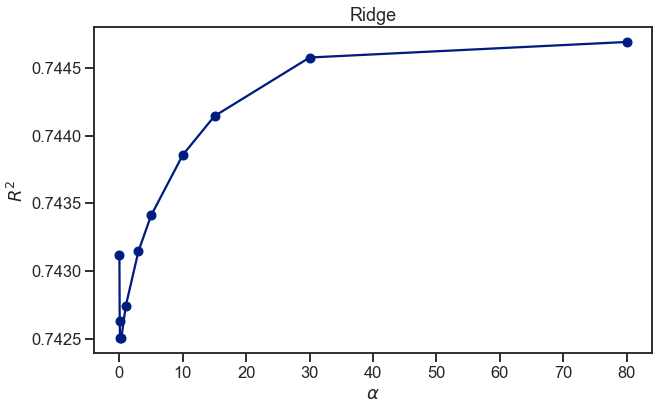

In [273]:
plt.figure(figsize=(10,6))
plt.plot(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')
plt.title('Ridge')

In [274]:
list(zip(alphas,scores))

[(0.005, 0.7431192799166194),
 (0.05, 0.7426319773327532),
 (0.1, 0.742507807772117),
 (0.3, 0.7425045093790238),
 (1, 0.7427429005554205),
 (3, 0.7431465066936096),
 (5, 0.7434111421735634),
 (10, 0.7438577038738992),
 (15, 0.7441439358760744),
 (30, 0.7445758417757911),
 (80, 0.7446903702224573)]

#### ElasticNet

In [295]:
l1_ratios = np.linspace(0.1, 0.9, 10)
alphas = np.geomspace(0.8, 5.0, 10)

scores = []
coefs = []
ratio = []
for alpha in alphas:
    for l1 in l1_ratios:
        Ela = ElasticNet(alpha=alpha, l1_ratio= l1, max_iter=100000)
        
        predictions = cross_val_predict(Ela, X2_trans, y, cv = kf)
        
        score = r2_score(y, predictions)

        ratio.append(l1)
        coefs.append(alpha)
        scores.append(score)

In [296]:
Ela_scores= list(zip(coefs,scores, ratio))

In [300]:
print(*map(max, zip(*Ela_scores)))

5.000000000000001 0.7359163350973976 0.9


### Conclusion and Future Work

As we saw Linear Regression performance was `0.742069142334017` which is not that bad compared to Lasso `0.7526505174162378` , Ridge `0.7445758417757911`, or ElasticNet `0.7359163350973976`

Tree-based model might perform better here, in addition to the zero-inflated data that we didn't deal with also have a bad effect on the overall prediction of the model